In [1]:

import _init_
from constants import *
from set_path import *
from config import *
from functions import *

In [2]:
cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)

In [3]:

file = '/g/data/jh2/av5889/quokka_myrepo/quokka/extern/grackle_data_files/input/CloudyData_UVB=HM2012.h5'
# file = '/g/data/jh2/av5889/quokka_myrepo/quokka/extern/grackle_data_files/input/CloudyData_UVB=FG2011.h5'
#Dim2 is redshift. Dim1 is density. Dim3 is temperature
grackle = h5py.File(file)
array = grackle['CoolingRates/Primordial/MMW'][()]
#density(1.e-6, 1.e4), redshift(0,15), temperature(10., 1.e9)
table = array[:,0,:]
table_nH   = np.logspace(-10, 4, array.shape[0])
table_temp = np.logspace(1,  9, array.shape[2])

prim_heating = grackle['CoolingRates/Primordial/Heating'][()][:,0,:]
prim_cooling = grackle['CoolingRates/Primordial/Cooling'][()][:,0,:]

met_heating  = grackle['CoolingRates/Metals/Heating'][()][:,0,:]
met_cooling  = grackle['CoolingRates/Metals/Cooling'][()][:,0,:]

netLambda_prim =  - prim_cooling 

netLambda_met  = - met_cooling
netLambda_Zsol = prim_cooling + met_cooling



In [4]:
LambdaZsol = interpolate.interp2d(table_temp, table_nH, netLambda_Zsol,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)

# Get Mu

In [6]:

i=0
bins = 100
egas_arr = np.logspace(-21., -5., bins)
nH_arr   = np.logspace(-6.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))

for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        def func(T):
            mu = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
            return C*mu(T,nH)[0] - T

        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

    
# temperature_table = interpolate.RectBivariateSpline(egas_arr, nH_arr, T)


In [7]:
mu_interp = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)

In [11]:
Zsim_list = [0.2, 1.0]

data_path = '/g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/'
file_list = ['R4-0.2Zsol/slice-6690000-xz.h5', 'R8/slice-6000000-xz.h5']

tcool_ratio = []
tcool_tdyn = []
temp_arr = []

for Zsim,file in zip(Zsim_list, file_list):

    infile   = os.path.join(data_path, file)
    hf = h5py.File(infile ,'r')
    rho_gas = hf['Rho'][:]
    rhoZ = hf['RhoZ'][:]
    eint = hf['IntEnergy'][:]
    xrange = hf['Xrange'][:]
    zrange = hf['Zrange'][:]
    temp = hf['Temperature'][:]
    
    
    rhoH = rho_gas * cloudy_H_mass_fraction
    nH =  rhoH / (mp + m_e)
    mu = np.zeros(temp.shape)
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            mu[i,j]  = np.vectorize(mu_interp)(temp[i,j].ravel(), nH[i,j].ravel())
            
            
    rhoH = rho_gas * cloudy_H_mass_fraction
    nH =  rhoH / (mp + m_e)
    lambdaZsol = np.zeros(temp.shape)
    for i in range(temp.shape[0]):
        lambdaZsol[i]  = np.vectorize(LambdaZsol)(temp[i].ravel(), nH[i].ravel())
        
    edot_tot = Zsim * (rhoH*rhoH*lambdaZsol/mp/mp)
    tcool_Zsim = eint/np.abs(edot_tot)
    
    Zmet = Zsim + (rhoZ*Msun/rho_gas /1.e3 /8.6e-3)
    edot_tot_true = Zmet*(rhoH*rhoH*lambdaZsol/mp/mp)
    tcool_true = eint/np.abs(edot_tot_true)
    
    
    cs = np.sqrt(1.4*boltzmann_constant_cgs * temp/mu/rho_gas)
    tdyn = 4.*kpc/cs
    
    tcool_ratio.append( (tcool_Zsim/tcool_true))
    tcool_tdyn.append( tcool_true/tdyn)
    temp_arr.append(temp)
    
 

In [18]:
tcool_ratio_arr = np.asarray(tcool_ratio)
tcool_tdyn_arr = np.asarray(tcool_tdyn)
temp_arr = np.asarray(temp_arr)

In [17]:
tcool_ratio.shape

(2, 512, 4096)

In [22]:
for i in range(2):
    temp = temp_arr[i]
    tcool_ratio = tcool_ratio_arr[i]
    tcool_tdyn = tcool_tdyn_arr[i]

tcool_tdyn.shape

(512, 4096)

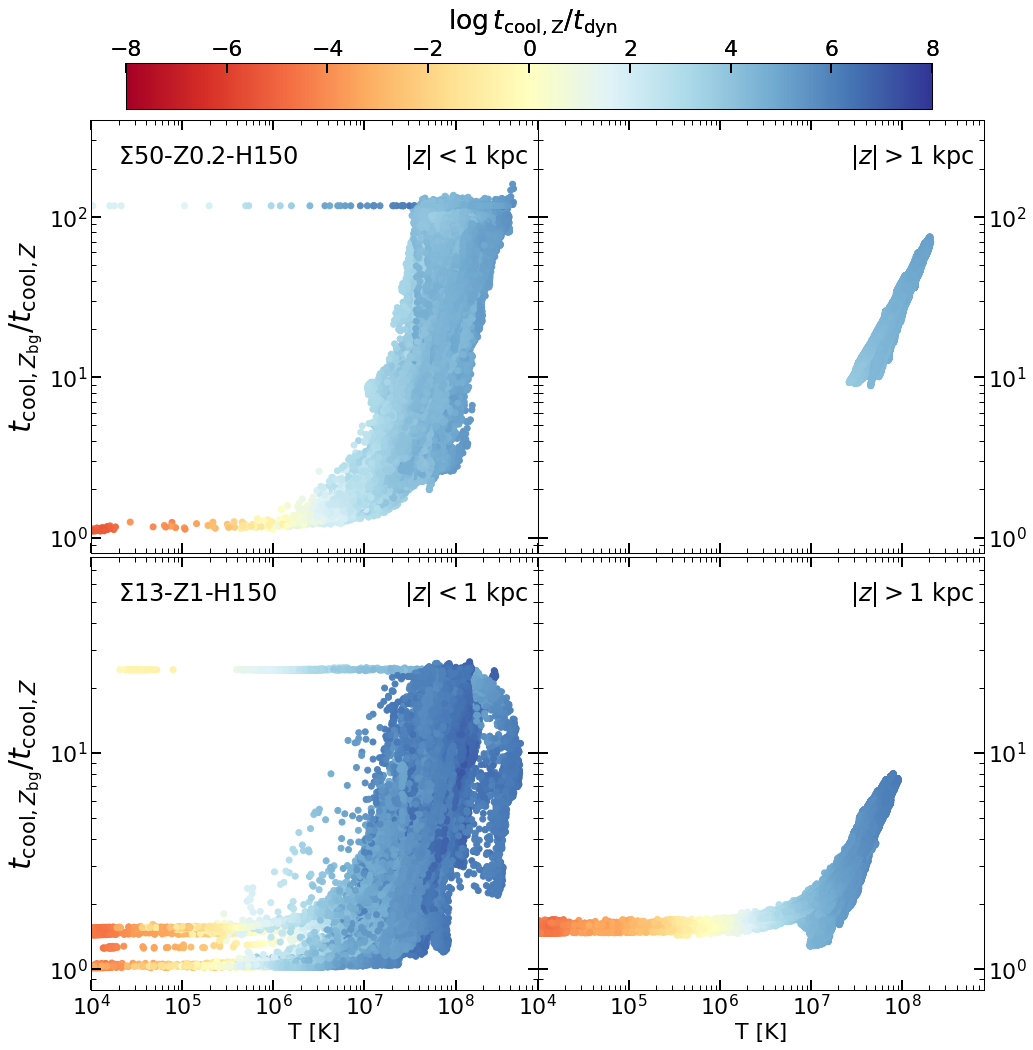

In [54]:

fig, ax = plt.subplots(2, 2, gridspec_kw = {'wspace':0.00, 'hspace':0.01},figsize=(16,16))

cbarx = 0.155
cbheight = 0.04
cbary = 0.89
cblen = 0.7

dx1 = 0.4
cbtitlex = 0.1


for i in range(2):
    temp = temp_arr[i]
    tcool_ratio = tcool_ratio_arr[i]
    tcool_tdyn = tcool_tdyn_arr[i]
    
    tmask = (temp>1.e4)
    outflow = (np.abs(zrange)>kpc)*tmask
    disc = (np.abs(zrange)<kpc)*tmask

    plot = ax[i,0].scatter(temp[disc].flatten(), tcool_ratio[disc].flatten(), \
                            c=np.log10(tcool_tdyn[disc]).flatten(), 
                            cmap='RdYlBu', vmin=-8, vmax=8.)
    cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
    fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-8, -6, -4, -2.,  0.0,  2., 4.0, 6.0, 8.0 ))
    cax.xaxis.set_ticks_position('top')
    cax.set_title(r" $\log t_{\rm cool,Z}/ t_{\rm dyn}$")



    plot = ax[i,1].scatter(temp[outflow].flatten(), tcool_ratio[outflow].flatten(), \
                            c=np.log10(tcool_tdyn[outflow]).flatten(), 
                            cmap='RdYlBu', vmin=-8, vmax=8.)

for i in range(2):
    ax[i,0].tick_params(axis='y', which='both', right=True, left=True, labelleft=True)
    ax[i,1].tick_params(axis='y', which='both', labelleft=False, labelright=True, right=True, left=True)
    ax[i,0].set_ylabel(r"$t_{{\rm cool},{Z_{\rm bg}}}/t_{{\rm cool},Z}$", fontsize=30)

    for j in range(2):
        ax[i,j].tick_params(axis='x', which='both', top=True)
        ax[0,j].tick_params(axis='x', which='both', top=True, bottom=True, labelbottom=False)

        
# ax[0,0].set_ylabel(r"$t_{{\rm cool},{Z_{\rm bg}}}/t_{{\rm cool},Z}$", fontsize=30)

plt.setp(ax, 'xscale',('log'))
plt.setp(ax, 'yscale',('log'))
plt.setp(ax, 'xlim', (1.e4, 8.e8))
# plt.setp(ax[1], 'xlim', (1.e4, 4.e8))
plt.setp(ax, 'ylim', (0.8, 4.e2))
plt.setp(ax[1,:], 'ylim', (0.8, 80.))
# ax[0].set_title('Outflow')
# ax[1].set_title('Disc')
plt.setp(ax, 'xlabel', 'T [K]')

ax[0,0].text(0.7, 0.9, r'$|z|<1$ kpc', transform=ax[0,0].transAxes, fontsize=24)
ax[0,1].text(0.7, 0.9, r'$|z|>1$ kpc', transform=ax[0,1].transAxes, fontsize=24)

ax[1,0].text(0.7, 0.9, r'$|z|<1$ kpc', transform=ax[1,0].transAxes, fontsize=24)
ax[1,1].text(0.7, 0.9, r'$|z|>1$ kpc', transform=ax[1,1].transAxes, fontsize=24)

ax[0,0].text(0.06, 0.9, r'$\Sigma50$-Z0.2-H150', transform=ax[0,0].transAxes, fontsize=24)
ax[1,0].text(0.06, 0.9, r'$\Sigma13$-Z1-H150', transform=ax[1,0].transAxes, fontsize=24)


plt.savefig(os.path.join(fig_path, "Paper", "tcool_tdyn.jpeg"), bbox_inches='tight', dpi=160)
